# 🌱 Carbon Emissions of GPUs in LLM Training
This project analyzes the energy consumption and estimated carbon emissions of different GPUs used in AI/LLM training.  
We use datasets containing GPU specifications, power consumption, and energy mix factors to estimate emissions.  


In [7]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import timedelta

# Plot style
sns.set_theme(style="whitegrid")
%matplotlib inline


In [8]:

GPU_SPECS_PATH = "/kaggle/input/carbon-footprint-calculation/gpu_specs_v7.csv"
BUTTER_E_PATH  = "/kaggle/input/carbon-footprint-calculation/butter_e_energy.csv"
EU_CO2_PATH    = "/kaggle/input/carbon-footprint-calculation/2017_CO2_IntensEL_EEA.csv"
OWID_PATH_ZIP  = "/kaggle/input/carbon-footprint-calculation/owid-energy.csv"

try:
    owid = pd.read_csv(OWID_PATH_ZIP)
except Exception:
  
    owid = pd.read_csv(OWID_PATH_ZIP + ".zip")


gpu_specs = pd.read_csv(GPU_SPECS_PATH)
butter_e  = pd.read_csv(BUTTER_E_PATH)
co2_eu    = pd.read_csv(EU_CO2_PATH)


print("gpu_specs:", gpu_specs.shape)
print("butter_e:", butter_e.shape)
print("co2_eu:", co2_eu.shape)
print("owid:", owid.shape)


gpu_specs: (3056, 16)
butter_e: (1059206, 3)
co2_eu: (924, 6)
owid: (21890, 129)


In [9]:
display(gpu_specs.head())
display(butter_e.head())
display(co2_eu.head())

display(owid[["country","year","carbon_intensity_elec"]].dropna().head())


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,manufacturer,productName,releaseYear,memSize,memBusWidth,gpuClock,memClock,unifiedShader,tmu,rop,pixelShader,vertexShader,igp,bus,memType,gpuChip
0,NVIDIA,GeForce RTX 5090,2025.0,28.0,448.0,900,1200.0,8192.0,256,128,NaN,NaN,No,PCIe 4.0 x16,HBM2e,Arctic Sound
1,NVIDIA,GeForce RTX 5080,2025.0,16.0,256.0,900,1215.0,6912.0,432,192,NaN,NaN,No,PCIe 4.0 x16,HBM2e,GA100
2,NVIDIA,GeForce RTX 5070,2025.0,12.0,192.0,1825,2000.0,5120.0,320,128,NaN,NaN,No,PCIe 4.0 x16,GDDR6,Navi 21
3,NVIDIA,GeForce RTX 5060 Mobile,2025.0,8.0,128.0,2235,2500.0,4608.0,144,48,NaN,NaN,No,PCIe 5.0 x16,GDDR7,GB206
4,NVIDIA,GeForce RTX 5060,2025.0,8.0,128.0,1825,2250.0,4608.0,288,192,NaN,NaN,No,PCIe 4.0 x16,GDDR6,Navi 31


,timestamp,node,watts
0,2022-09-24T08:20:01.000Z,r103u05,721
1,2022-09-24T08:21:01.000Z,r103u05,470
2,2022-09-24T08:22:01.000Z,r103u05,461
3,2022-09-24T08:23:01.000Z,r103u05,458
4,2022-09-24T08:24:01.000Z,r103u05,462


,CountryShort,CountryLong,Year,ValueNumeric,Unit,Data_source
0,EU28,EU-28,1990,531.232975,gCO2/kWh,EEA
1,EU28,EU-28,1991,516.034467,gCO2/kWh,EEA
2,EU28,EU-28,1992,503.571112,gCO2/kWh,EEA
3,EU28,EU-28,1993,473.999118,gCO2/kWh,EEA
4,EU28,EU-28,1994,469.013303,gCO2/kWh,EEA


,country,year,carbon_intensity_elec
100,Afghanistan,2000,255.319
101,Afghanistan,2001,118.644
102,Afghanistan,2002,144.928
103,Afghanistan,2003,255.319
104,Afghanistan,2004,269.663


In [10]:

g = gpu_specs.copy()


g = g.rename(columns={
    "productName": "product_name",
    "releaseYear": "release_year",
    "memSize": "mem_size",
    "memBusWidth": "mem_bus_width",
    "gpuClock": "gpu_clock",
    "memClock": "mem_clock",
    "unifiedShader": "unified_shader",
    "gpuChip": "gpu_chip"
})

for col in ["release_year","mem_size","mem_bus_width","gpu_clock","mem_clock","unified_shader"]:
    if col in g.columns:
        g[col] = pd.to_numeric(g[col], errors="coerce")

g["product_name"] = g["product_name"].astype(str).str.strip()

g.info()
display(g[["product_name","manufacturer","release_year","mem_size","gpu_clock","unified_shader"]].head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3056 entries, 0 to 3055
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   manufacturer    3056 non-null   object 
 1   product_name    3056 non-null   object 
 2   release_year    3012 non-null   float64
 3   mem_size        2615 non-null   float64
 4   mem_bus_width   188 non-null    float64
 5   gpu_clock       3056 non-null   int64  
 6   mem_clock       2615 non-null   float64
 7   unified_shader  2232 non-null   float64
 8   tmu             3056 non-null   int64  
 9   rop             3056 non-null   int64  
 10  pixelShader     824 non-null    float64
 11  vertexShader    824 non-null    float64
 12  igp             3056 non-null   object 
 13  bus             3056 non-null   object 
 14  memType         2615 non-null   object 
 15  gpu_chip        3056 non-null   object 
dtypes: float64(7), int64(3), object(6)
memory usage: 382.1+ KB


,product_name,manufacturer,release_year,mem_size,gpu_clock,unified_shader
0,GeForce RTX 5090,NVIDIA,2025.0,28.0,900,8192.0
1,GeForce RTX 5080,NVIDIA,2025.0,16.0,900,6912.0
2,GeForce RTX 5070,NVIDIA,2025.0,12.0,1825,5120.0
3,GeForce RTX 5060 Mobile,NVIDIA,2025.0,8.0,2235,4608.0
4,GeForce RTX 5060,NVIDIA,2025.0,8.0,1825,4608.0


In [11]:

tdp_cols = [c for c in g.columns if c.lower().startswith("tdp") or "power" in c.lower()]
print("Detected TDP-like columns:", tdp_cols)

MANUAL_TDP = {
   
}

def estimate_tdp_from_specs(row):
    """
    Heuristic TDP estimator when TDP column not present.
    Formula is intentionally conservative and approximate.
    Replace with MANUAL_TDP entries for accuracy.
    """
    
    name = str(row.get("product_name",""))
    for k,v in MANUAL_TDP.items():
        if k.lower() in name.lower():
            return float(v)
    
    for tc in tdp_cols:
        val = row.get(tc, None)
        if pd.notna(val):
            try:
                return float(val)
            except:
                pass
    
    unified = float(row.get("unified_shader") or 0)
    clock = float(row.get("gpu_clock") or 0)
    mem = float(row.get("mem_size") or 0)
    
    score = (unified * (clock if clock>0 else 1000)) / 1e6  
    
    est = 50 + score * 35 + mem * 2.0
    
    est = max(30.0, min(est, 700.0))
    return round(est, 1)


g["est_tdp_watts"] = g.apply(estimate_tdp_from_specs, axis=1)

display(g[["product_name","manufacturer","mem_size","unified_shader","gpu_clock","est_tdp_watts"]].sample(8))


Detected TDP-like columns: []


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,product_name,manufacturer,mem_size,unified_shader,gpu_clock,est_tdp_watts
2332,Radeon X1650 PRO AGP,ATI,0.256,144.0,650,53.8
709,Tesla P100 DGXS,NVIDIA,16.000,3328.0,1825,294.6
331,GeForce RTX 3080,NVIDIA,10.000,2048.0,1192,155.4
313,GRID A100B,NVIDIA,48.000,3840.0,1303,321.1
594,Radeon RX Vega 11,AMD,NaN,NaN,250,30.0
1113,Radeon R6 M255DX,AMD,NaN,NaN,250,30.0
772,GeForce GTX 965M,NVIDIA,2.000,384.0,1041,68.0
2862,GeForce2 MX 400 PCI,NVIDIA,0.032,NaN,450,30.0


In [13]:

co2_eu_clean = co2_eu.copy()
co2_eu_clean = co2_eu_clean.rename(columns={
    "CountryShort":"country_short","CountryLong":"country_long",
    "Year":"year","ValueNumeric":"value_numeric"
})
co2_eu_clean["kgCO2_per_kwh"] = pd.to_numeric(co2_eu_clean["value_numeric"], errors="coerce")/1000.0


owid_ci = owid[["country","year","carbon_intensity_elec"]].copy()
owid_ci["carbon_intensity_elec"] = pd.to_numeric(owid_ci["carbon_intensity_elec"], errors="coerce")


GLOBAL_FALLBACK_INTENSITY = 0.475  


In [14]:
def get_carbon_intensity(country_name, year):
    """
    Returns carbon intensity in kgCO2/kWh given country string and year (int).
    Priority: OWID (country match, year) -> EU dataset (CountryLong/Short) -> GLOBAL_FALLBACK_INTENSITY
    """
    
    try:
        r = owid_ci[(owid_ci["country"].str.lower()==country_name.lower()) & (owid_ci["year"]==int(year))]
        if not r.empty and pd.notna(r.iloc[0]["carbon_intensity_elec"]):
            return float(r.iloc[0]["carbon_intensity_elec"])
    except Exception:
        pass
    
    try:
        r2 = co2_eu_clean[(co2_eu_clean["country_long"].str.lower()==country_name.lower()) & (co2_eu_clean["year"]==int(year))]
        if r2.empty:
            r2 = co2_eu_clean[(co2_eu_clean["country_short"].str.lower()==country_name.lower()) & (co2_eu_clean["year"]==int(year))]
        if not r2.empty and pd.notna(r2.iloc[0]["kgCO2_per_kwh"]):
            return float(r2.iloc[0]["kgCO2_per_kwh"])
    except Exception:
        pass
        
    return GLOBAL_FALLBACK_INTENSITY


for c,y in [("United States",2017),("India",2017),("EU-28",1990)]:
    print(c,y,get_carbon_intensity(c,y))


United States 2017 416.784
India 2017 658.208
EU-28 1990 0.5312329746000001


In [15]:
def watts_hours_to_kwh(watts, hours):
    """ watts * hours -> Wh; divide by 1000 -> kWh """
    return (watts * hours) / 1000.0

def estimate_emissions_kg(watts, hours, country="United States", year=2017):
    """
    Estimate kg CO2 for given GPU wattage and runtime (hours).
    Uses get_carbon_intensity(country, year) -> kgCO2/kWh
    """
    kwh = watts_hours_to_kwh(watts, hours)
    intensity = get_carbon_intensity(country, year)
    return kwh * intensity

print("Example 400W 24h in US 2017 (kgCO2):", estimate_emissions_kg(400, 24, "United States", 2017))


Example 400W 24h in US 2017 (kgCO2): 4001.1263999999996


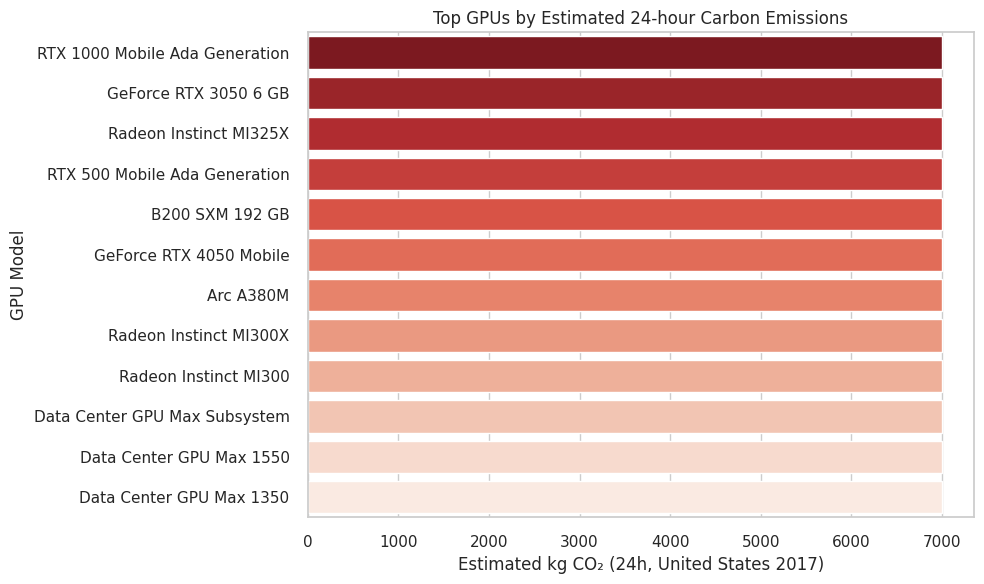

,product_name,manufacturer,est_tdp_watts,emission_24h_kgco2
0,RTX 1000 Mobile Ada Generation,NVIDIA,700.0,7001.9712
1,GeForce RTX 3050 6 GB,NVIDIA,700.0,7001.9712
2,Radeon Instinct MI325X,AMD,700.0,7001.9712
3,RTX 500 Mobile Ada Generation,NVIDIA,700.0,7001.9712
4,B200 SXM 192 GB,NVIDIA,700.0,7001.9712
5,GeForce RTX 4050 Mobile,NVIDIA,700.0,7001.9712
6,Arc A380M,Intel,700.0,7001.9712
7,Radeon Instinct MI300X,AMD,700.0,7001.9712
8,Radeon Instinct MI300,AMD,700.0,7001.9712
9,Data Center GPU Max Subsystem,Intel,700.0,7001.9712


In [16]:

df = g.copy()
HOURS = 24  

df["emission_24h_kgco2"] = df["est_tdp_watts"].apply(lambda w: estimate_emissions_kg(w, HOURS, country="United States", year=2017))

top_emitters = df.nlargest(12, "emission_24h_kgco2")[["product_name","manufacturer","est_tdp_watts","emission_24h_kgco2"]]

plt.figure(figsize=(10,6))
sns.barplot(x="emission_24h_kgco2", y="product_name", data=top_emitters, palette="Reds_r")
plt.xlabel("Estimated kg CO₂ (24h, United States 2017)")
plt.ylabel("GPU Model")
plt.title("Top GPUs by Estimated 24-hour Carbon Emissions")
plt.tight_layout()
plt.show()

top_emitters.reset_index(drop=True)


In [17]:
be = butter_e.copy()

be["timestamp"] = pd.to_datetime(be["timestamp"], errors="coerce")
be = be.sort_values("timestamp").reset_index(drop=True)


be["delta_hours"] = be["timestamp"].diff().dt.total_seconds() / 3600.0

median_delta = be["delta_hours"].median(skipna=True)
be.loc[0,"delta_hours"] = median_delta if pd.notna(median_delta) else 1/60.0  


be["kwh_interval"] = (be["watts"] * be["delta_hours"]) / 1000.0
total_kwh_measured = be["kwh_interval"].sum()

print(f"BUTTER-E measured total energy over dataset: {total_kwh_measured:.3f} kWh")
print(f"Average measured power: {be['watts'].mean():.1f} W (sample)")


BUTTER-E measured total energy over dataset: 65.341 kWh
Average measured power: 260.1 W (sample)


In [18]:

country_choice = "United States"   
year_choice = 2017                 

ci = get_carbon_intensity(country_choice, year_choice)
emissions_butter_kg = total_kwh_measured * ci

print(f"Using carbon intensity {ci:.3f} kgCO2/kWh for {country_choice} {year_choice}")
print(f"BUTTER-E measured emissions ≈ {emissions_butter_kg:.2f} kg CO2")


Using carbon intensity 416.784 kgCO2/kWh for United States 2017
BUTTER-E measured emissions ≈ 27233.20 kg CO2


In [19]:

mean_watts_measured = be["watts"].mean()


candidate_substr = "A100"  
candidates = df[df["product_name"].str.contains(candidate_substr, case=False, na=False)]

if not candidates.empty:
    cand_row = candidates.iloc[0]
    est_tdp = cand_row["est_tdp_watts"]
    print(f"Candidate GPU: {cand_row['product_name']} estimated TDP = {est_tdp} W")
    print(f"Average measured watts in BUTTER-E: {mean_watts_measured:.1f} W")
    print(f"Measured/Estimated ratio: {mean_watts_measured/est_tdp:.2f}")
else:
    print(f"No GPU matching '{candidate_substr}' found in gpu specs. Measured avg watts: {mean_watts_measured:.1f} W")


Candidate GPU: RTX A1000 estimated TDP = 291.0 W
Average measured watts in BUTTER-E: 260.1 W
Measured/Estimated ratio: 0.89


In [20]:
def simulate_llm_training(gpu_watts=400, gpu_hours=1000, country="United States", year=2017):
    """Return dict with energy (kWh) and emissions (kgCO2)."""
    kwh = watts_hours_to_kwh(gpu_watts, gpu_hours)
    intensity = get_carbon_intensity(country, year)
    emissions = kwh * intensity
    return {"gpu_watts":gpu_watts, "gpu_hours":gpu_hours, "kwh":kwh, "intensity_kgCO2_per_kwh":intensity, "emissions_kgCO2":emissions}


res = simulate_llm_training(400, 1000, country="United States", year=2017)
print("LLM training example (400W, 1000 hours):")
print(res)


LLM training example (400W, 1000 hours):
{'gpu_watts': 400, 'gpu_hours': 1000, 'kwh': 400.0, 'intensity_kgCO2_per_kwh': 416.784, 'emissions_kgCO2': 166713.6}


In [21]:

OUT_DIR = "/kaggle/working/carbon_results"
os.makedirs(OUT_DIR, exist_ok=True)

df_out = df[["product_name","manufacturer","release_year","mem_size","unified_shader","est_tdp_watts","emission_24h_kgco2"]].copy()
df_out.to_csv(os.path.join(OUT_DIR,"gpu_emission_estimates_24h.csv"), index=False)


be_summary = pd.DataFrame({
    "total_kwh_measured":[total_kwh_measured],
    "avg_power_w":[be["watts"].mean()],
    "butter_emissions_kg":[emissions_butter_kg],
    "country_used":[country_choice],
    "year_used":[year_choice]
})
be_summary.to_csv(os.path.join(OUT_DIR,"butter_e_summary.csv"), index=False)

print("Saved results to", OUT_DIR)


Saved results to /kaggle/working/carbon_results
